CSCI 4852 & 6952: Deep Learning (Fall2023)  

Instructor: Alina Lazar (alazar@ysu.edu)  
GitHub repository:https://github.com/alinutzal/CSCI-xx52-Deep-Learning-

# ADALINE with Stochastic Gradient Descent (Minibatch)

![](figures/adaline-concept.png)

In this notebook, we are implementing ADALINE "by hand" without using PyTorch's autograd capabilities. In Lecture 06, we will use "automatic differentiation" (also known as "autodiff"; or autograd in PyTorch) to implement Adaline more compactly. (The reason why we don't use autodiff here is that it is useful to understand what's going on under the hood.) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

<br>
<br>

## Load & Prepare a Toy Dataset

In [3]:
df = pd.read_csv('./datasets/iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.tail()

,x1,x2,x3,x4,y
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [10]:
# Assign features and target

X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma
len(X_test)

30

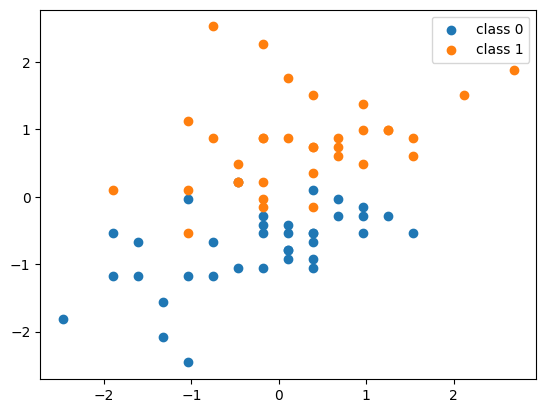

In [5]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 1')
plt.legend()
plt.show()

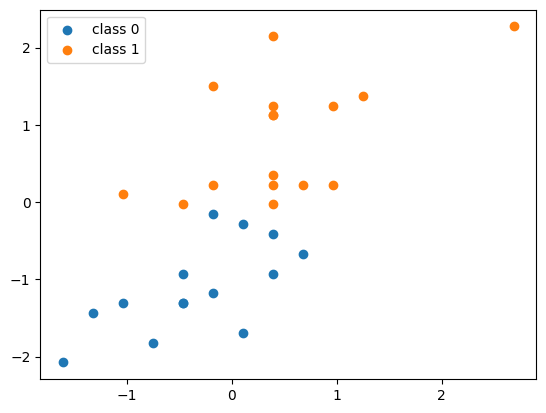

In [6]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.legend()
plt.show()

<br>
<br>

## Implement ADALINE Model

In [7]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(yhat - y)
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights = torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions

In [11]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

<br>
<br>

## Train Model

In [12]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.1,
             seed=123,
             minibatch_size=10)

    Minibatch MSE: 0.500
    Minibatch MSE: 0.341
    Minibatch MSE: 0.220
    Minibatch MSE: 0.245
    Minibatch MSE: 0.157
    Minibatch MSE: 0.133
    Minibatch MSE: 0.144
Epoch: 001 | MSE: 0.12142
    Minibatch MSE: 0.107
    Minibatch MSE: 0.147
    Minibatch MSE: 0.064
    Minibatch MSE: 0.079
    Minibatch MSE: 0.185
    Minibatch MSE: 0.063
    Minibatch MSE: 0.135
Epoch: 002 | MSE: 0.09932
    Minibatch MSE: 0.093
    Minibatch MSE: 0.064
    Minibatch MSE: 0.128
    Minibatch MSE: 0.099
    Minibatch MSE: 0.079
    Minibatch MSE: 0.157
    Minibatch MSE: 0.080
Epoch: 003 | MSE: 0.09693
    Minibatch MSE: 0.131
    Minibatch MSE: 0.146
    Minibatch MSE: 0.050
    Minibatch MSE: 0.095
    Minibatch MSE: 0.106
    Minibatch MSE: 0.072
    Minibatch MSE: 0.102
Epoch: 004 | MSE: 0.09658
    Minibatch MSE: 0.107
    Minibatch MSE: 0.204
    Minibatch MSE: 0.149
    Minibatch MSE: 0.054
    Minibatch MSE: 0.060
    Minibatch MSE: 0.056
    Minibatch MSE: 0.069
Epoch: 005 | MSE: 0.0

<br>
<br>

## Evaluate ADALINE Model

### Plot Loss (MSE)

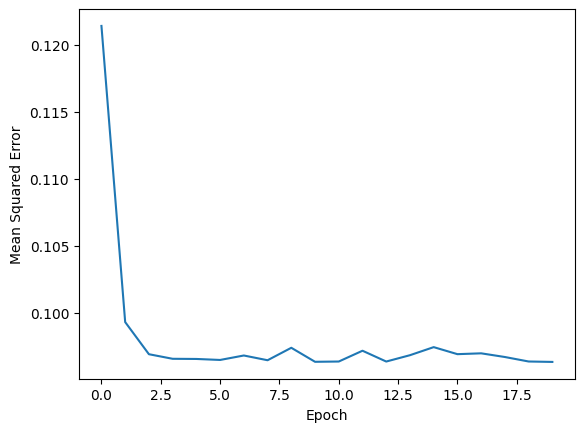

In [13]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

<br>
<br>

### Compare with analytical solution

In [14]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-0.0763],
        [ 0.4181]])
Bias tensor([0.4888])


In [15]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train.float())
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[-0.0703],
        [ 0.4219]])
Analytical bias tensor([0.4857])


<br>
<br>

## Evaluate on Evaluation Metric (Prediction Accuracy)

In [20]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())

train_pred = model.forward(X_train)
print(y_train,"\n",train_pred)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       dtype=torch.int32) 
 tensor([ 0.7675,  0.3932,  0.4248,  0.3080,  0.0746,  0.6191,  0.1890,  0.6071,
         0.3299,  0.1792,  0.1476,  0.3834,  0.5001,  0.6191,  0.8089,  0.0844,
         0.2327,  0.6266,  0.8647,  0.1183,  0.8428,  0.1453,  0.7457,  0.2546,
         0.0527,  0.1401,  0.6168,  0.8647,  0.8308,  0.3178,  0.7675,  0.5973,
         0.0188, -0.2779,  0.2327,  0.0723,  0.9912,  1.2172,  0.3322,  0.7336,
         0.9084,  0.0625,  0.9573,  0.6191,  1.4530,  1.0740,  0.2764,  0.1476,
         0.4369,  0.3495,  0.6094,  0.6922,  1.0372,  0.0941,  0.2666,  1.6036,
         0.7261,  0.6749,  0.2960, -0.0640, -0.4602,  0.4075,  0.3420,  0.2741,
         0.8089,  0.7991,  0.4903,  0.5559, -0.0836,  1.0884])
Training Accuracy: 90.00
Test Accu

<br>
<br>

## Decision Boundary

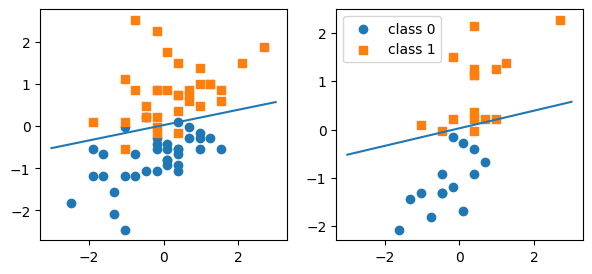

In [21]:
##########################
### 2D Decision Boundary
##########################

w, b = model.weights, model.bias - 0.5

x_min = -3
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] ).numpy()

x_max = 3
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] ).numpy()


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()